# SageMaker - Hypeparameter Tuning - Using Notebook

#### Set up Environment

In [2]:
import os
import json
import sagemaker
from sagemaker.tensorflow import TensorFlow
from sagemaker import get_execution_role

A **boto3** session object to manage interactions with the Amazon SageMaker APIs.

An **execution role** which is passed to SageMaker to access your AWS resources.

In [3]:
sess = sagemaker.Session()
role = get_execution_role()

#### Download Data

Download the MNIST data from a public S3 bucket and save it in a temporary directory.

In [5]:
import logging
import boto3
from botocore.exceptions import ClientError

In [6]:
public_bucket = "sagemaker-sample-files"
local_data_dir = "/tmp/data"

Download training and testing data from a public S3 bucket.

In [8]:
def download_from_s3(data_dir="/tmp/data", train=True):
    
    # Project Root
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
        
    if train:
        images_file = "train-images-idx3-ubyte.gz"
        labels_file = "train-labels-idx1-ubyte.gz"
    else:
        images_file = "t10k-images-idx3-ubyte.gz"
        labels_file = "t10k-labels-idx1-ubyte.gz"
        
    # download objects
    s3 = boto3.client("s3")
    bucket = public_bucket
    
    for obj in [images_file, labels_file]:
        key = os.path.join("datasets/image/MNIST", obj)
        dest = os.path.join(data_dir, obj)
        if not os.path.exists(dest):
            s3.download_file(bucket, key, dest)
    return

download_from_s3(local_data_dir, True)
download_from_s3(local_data_dir, False)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


#### Run a TensorFlow Training Job

In [18]:
!pygmentize 'code/train.py'

Error: cannot read infile: [Errno 2] No such file or directory: 'code/train.py'


In [23]:
tf_estimator = TensorFlow(
                            entry_point="tf_hyperparameter_train.py",
                            role=role,
                            framework_version="2.3.1",
                            model_dir="/opt/ml/model",
                            py_version="py37",
                            instance_type="ml.m5.4xlarge",
                            instance_count=1,
                            volume_size=250,
                            hyperparameters={
                                "batch-size": 512,
                                "epochs": 4,
                            },
                        )

#### Set Up Channels for Training and Testing Data

In [24]:
prefix = "mnist"
bucket = sess.default_bucket()
loc = sess.upload_data(path=local_data_dir, bucket=bucket, key_prefix=prefix)

channels = {"training": loc, "testing": loc}

#### Run a Hyperparameter Tuning Job

**Steps:**

- Define the ranges of hyperparameters we plan to tune. In this example, we tune the learning rate.
- Define the objective metric for the tuning job to optimize. 
- Create a hyperparameter tuner with the above setting, as well as tuning resource configurations.

`CategoricalParameter(list)` - Takes one value from a discrete set.

`ContinuousParameter(min, max)` - Takes any real number value between the minimum and maximum.

`IntegerParameter(min, max)` - Takes any integer value between the minimum and maximum value.

Define **hyperparameter** and **range**.

In [25]:
from sagemaker.tuner import ContinuousParameter, HyperparameterTuner

hyperparamter_range = {"learning-rate": ContinuousParameter(1e-4, 1e-3)}

Define **Objective Metric**

In [26]:
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [
    {
        "Name": "average test loss",
        "Regex": "Test Loss: ([0-9\\.]+)",
    }
]

Create **HyperparameterTuner**

In [27]:
tuner = HyperparameterTuner(
    tf_estimator,
    objective_metric_name,
    hyperparamter_range,
    metric_definitions,
    max_jobs=3,
    max_parallel_jobs=3,
    objective_type=objective_type,
)

Fit Tuner

In [28]:
tuner.fit(inputs=channels)

......................................!


#### Deploy the Best Model

In [30]:
predictor = tuner.deploy(initial_instance_count=1, instance_type="ml.t2.large")


2022-05-04 01:50:54 Starting - Preparing the instances for training
2022-05-04 01:50:54 Downloading - Downloading input data
2022-05-04 01:50:54 Training - Training image download completed. Training in progress.
2022-05-04 01:50:54 Uploading - Uploading generated training model
2022-05-04 01:50:54 Completed - Training job completed

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.



-----!

We can see the Hyperparameter Tuner in AWS Sagemaker.

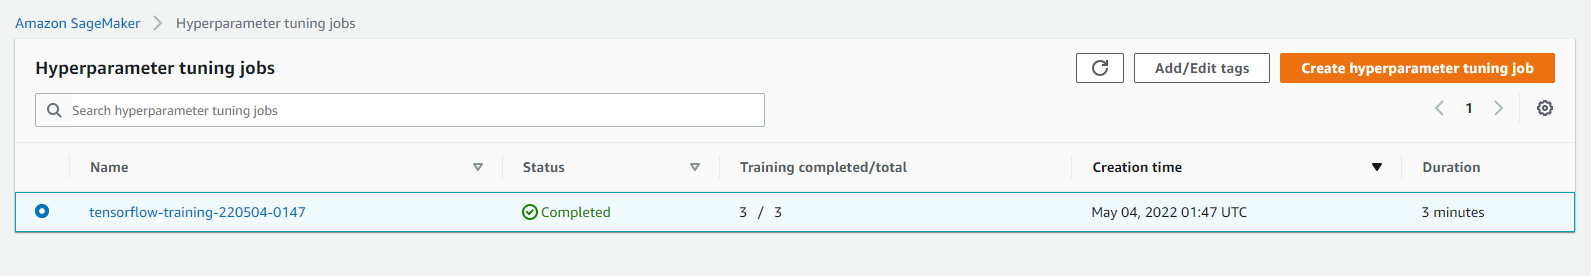

#### Evaluate

In [31]:
import random
import gzip
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

images_file = "t10k-images-idx3-ubyte.gz"

Matplotlib is building the font cache; this may take a moment.


In [32]:
def read_mnist(data_dir, images_file):
    with gzip.open(os.path.join(data_dir, images_file), "rb") as f:
        images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)
    return images

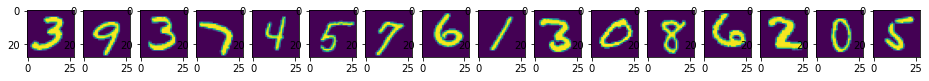

In [33]:
X = read_mnist(local_data_dir, images_file)

# Randomly sample 16 images to inspect
mask = random.sample(range(X.shape[0]), 16)
samples = X[mask]

# Plot the images
fig, axs = plt.subplots(nrows=1, ncols=16, figsize=(16, 1))

for i, splt in enumerate(axs):
    splt.imshow(samples[i])

Preprocess the data to be consumed by the model

In [34]:
def normalize(x, axis):
    eps = np.finfo(float).eps

    mean = np.mean(x, axis=axis, keepdims=True)
    # avoid division by zero
    std = np.std(x, axis=axis, keepdims=True) + eps
    return (x - mean) / std

In [35]:
samples = normalize(samples, axis=(1, 2))
samples = np.expand_dims(samples, axis=3)

#### Make Prediction

In [36]:
predictions = predictor.predict(samples)["predictions"]

# softmax to logit
predictions = np.array(predictions, dtype=np.float32)
predictions = np.argmax(predictions, axis=1)

print("Predictions: ", *predictions)

Predictions:  3 9 3 7 4 5 7 6 1 3 0 8 6 2 0 5


#### Cleanup

In [40]:
bucket_to_delete = boto3.resource('s3').Bucket(bucket)
bucket_to_delete.objects.all().delete()
predictor.delete_endpoint()

[{'ResponseMetadata': {'RequestId': 'DE5YT86TXC1FR73B',
   'HostId': 'X7myvwkCgjL2I+hEprnoyy0jFEdyB/u2XInYBw8pkwbhKRubmhWCckpXFA2BUgWqQZUqutXylOU=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': 'X7myvwkCgjL2I+hEprnoyy0jFEdyB/u2XInYBw8pkwbhKRubmhWCckpXFA2BUgWqQZUqutXylOU=',
    'x-amz-request-id': 'DE5YT86TXC1FR73B',
    'date': 'Wed, 04 May 2022 01:58:40 GMT',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3',
    'connection': 'close'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'tensorflow-training-220504-0147-002-858450c4/output/model.tar.gz'},
   {'Key': 'tensorflow-training-2022-05-04-01-47-52-188/source/sourcedir.tar.gz'},
   {'Key': 'tensorflow-training-220504-0147-001-7e823f6f/output/model.tar.gz'},
   {'Key': 'tensorflow-training-220504-0147-003-21912c0d/output/model.tar.gz'},
   {'Key': 'mnist/train-labels-idx1-ubyte.gz'},
   {'Key': 'mnist/train-images-idx3-ubyte.gz'},
   {'Key': 'mnist/t10k-images-idx3-ubyte